## Delta-Tolling Demonstration
Demonstration of scaling using local observation

In [1]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np

num_agents = 40
env_shape = (20,20)
big_world = np.zeros(env_shape)
big_agent = np.random.permutation([1] * num_agents + [0] * 
                                  (env_shape[0] * env_shape[0] - num_agents)).reshape(env_shape)
big_env = WarehouseEnv(agent_map=np.array(big_agent), obstacle_map=np.array(big_world), 
                        local_obseration_size=(9,7), render_as_observation=True)

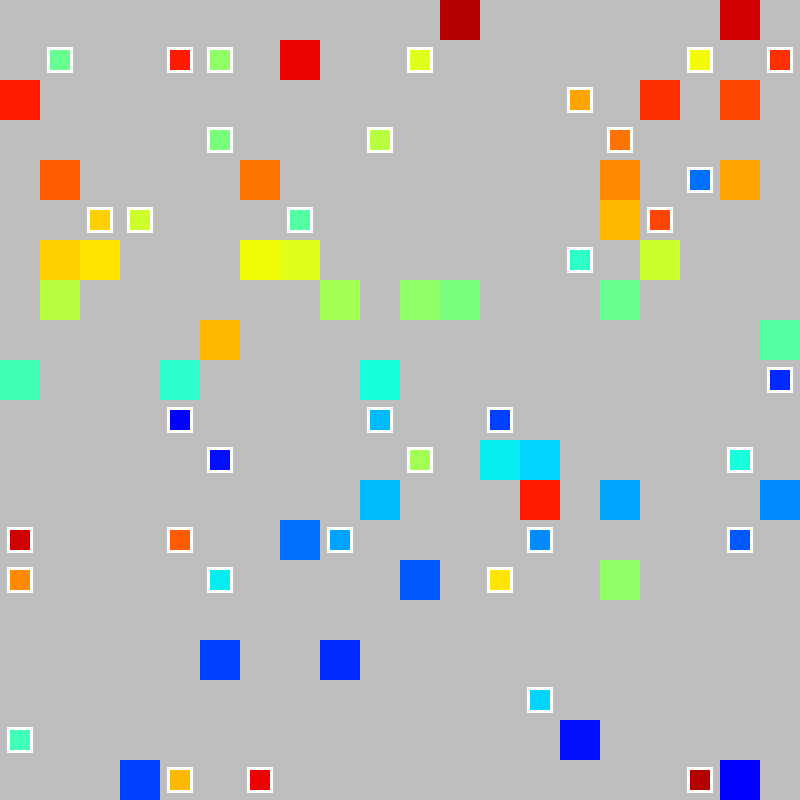

In [2]:
big_env.render(zoom_size=40, local=False)

#### Global Delta-Tolling with Local A*

In [17]:
from od_mstar3 import cpp_mstar
import networkx as nx

def get_next_action(env, env_graph, coordinated_planner=False):
    if coordinated_planner:
        states = [(v[0], v[1]) for k, v in env.agent_state.items()]
        goals = [(v[0], v[1]) for k, v in env.agent_goal.items()]
        path = None
        start_x, start_y = None, None
        next_x, next_y = None, None

        try:
            path = cpp_mstar.find_path(env.obstacle_map, states, goals, 10, 5 * 60.0)

            start_x, start_y = env.agent_state[env.current_agent_id]
            next_x, next_y = path[1][env.current_agent_id]   
        except:
            coordinated_planner = False

    if not coordinated_planner:
        location = env.agent_state[env.current_agent_id]
        goal = env.agent_goal[env.current_agent_id]

        path = nx.astar_path(env_graph, (location[0], location[1]), 
                             (goal[0], goal[1]), weight='weight')

        action = None
        start_x, start_y = path[0]
        next_x, next_y = path[1]
        
    if (start_y + 1)  == next_y:
        return_val = 0
    elif (start_y - 1) == next_y:
        return_val = 2
    elif (start_x - 1) == next_x:
        return_val = 1
    elif (start_x + 1) == next_x:
        return_val = 3
    else:
        return_val = 4
    
    return return_val

In [24]:
#Run the env
observation = big_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(big_env.render(zoom_size=40, agent_id=None))
    action = get_next_action(big_env, big_env.env_graph, coordinated_planner=False)
    big_env.step(action)
    old_tolls[t] = big_env.toll_map.copy()

frames[0].save('gif/big_gym_animation_astar_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)

#### Global Delta-Tolling with Local RL-Agent

In [26]:
from stable_baselines import A2C, A2CWithExperts

model_file = "/Users/pehuen/Downloads/log_14"
a2c_model = A2C.load(model_file + "/model.zip")

Loading a model without an environment, this model cannot be trained until it has a valid environment.
self.processed_obs Tensor("input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("model/Max:0", shape=(?, 2, 64), dtype=float32)
self.processed_obs Tensor("train_model/input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("train_model/model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("train_model/model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("train_model/model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("train_model/model/Max:0", shape=(?, 2, 64), dtype=float32)

In [49]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np

num_agents = 4
env_shape = (20,20)
big_world = np.zeros(env_shape)
big_sparse_agent = np.random.permutation([1] * num_agents + [0] * 
                                  (env_shape[0] * env_shape[0] - num_agents)).reshape(env_shape)
big_sparse_env = WarehouseEnv(agent_map=np.array(big_sparse_agent), obstacle_map=np.array(big_world), 
                        local_obseration_size=(9,7), render_as_observation=True)

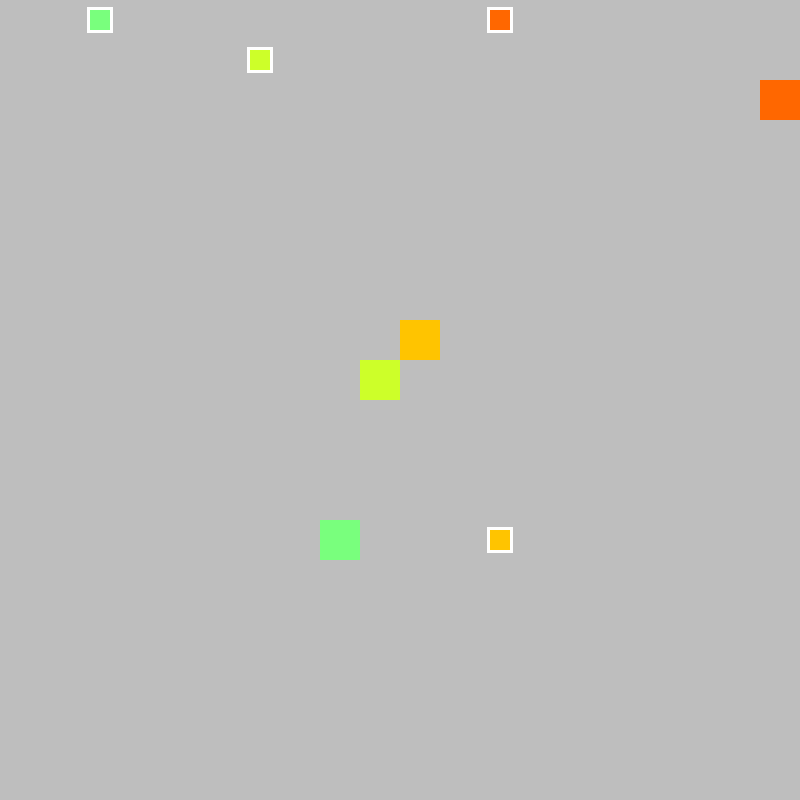

In [50]:
big_sparse_env.render(zoom_size=40, local=False)

In [52]:
#Run the env
obs = big_sparse_env.reset()
frames = []
episode_rewards = 0.0
states = a2c_model.initial_state
actions = []
old_tolls = {}

for t in range(1000):
    frames.append(big_sparse_env.render(zoom_size=40, agent_id=None, local=False))
    action, _states = a2c_model.predict(big_sparse_env._observe())#agent_id=0))
    actions.append(action)
    
    obs, reward, done, info = big_sparse_env.step(action)#, agent_id=0)
    
    episode_rewards += reward

    old_tolls[t] = big_sparse_env.toll_map.copy()

frames[0].save('gif/big_sparse_gym_animation_relational_astar_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=125, loop=0)

In [39]:
#Run the env
obs = big_env.reset()
frames = []
episode_rewards = 0.0
states = a2c_model.initial_state
actions = []
old_tolls = {}

for t in range(1000):
    frames.append(big_env.render(zoom_size=40, agent_id=None, local=False))
    action, _states = a2c_model.predict(big_env._observe())#agent_id=0))
    actions.append(action)
    
    obs, reward, done, info = big_env.step(action)#, agent_id=0)
    
    episode_rewards += reward

    old_tolls[t] = big_env.toll_map.copy()

frames[0].save('gif/big_gym_animation_relational_astar_1000.gif',
               save_all=True, append_images=frames[1::40], 
               optimize=False, duration=15, loop=0)

### Large Congested Environment